#### 1、测试laspy库读取las数据元数据

In [39]:
import laspy
filepath='lidar.las'
las = laspy.read(filepath)
print(len(las.x))#打印x数组，也就是lidar点个数
print(len(las.y))#打印y数组，也就是lidar点个数
print(len(las.z))#打印z数组，也就是lidar点个数
print(las.header.min)#获取x,y,z最小值[xmin, ymin, zmin]数组
print(las.header.max)#获取x,y,z最大值[xmax, ymax, zmax]数组

544
544
544
[2.7790019e+05 6.1223965e+06 4.6880000e+01]
[2.77975100e+05 6.12247149e+06 6.32400000e+01]


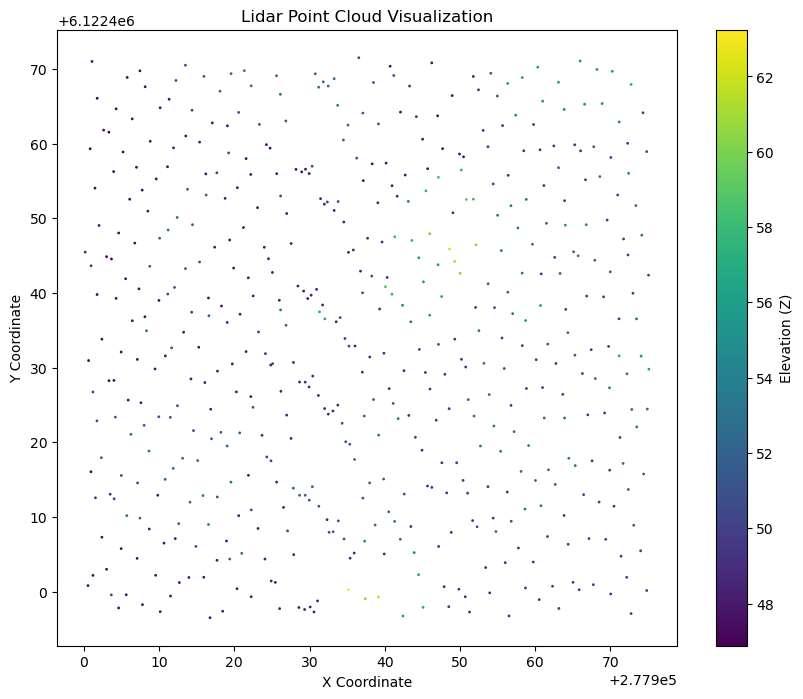

In [40]:
#可视化点云数据，使用matplotlib，二维显示，颜色代表z
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sc = plt.scatter(las.x, las.y, c=las.z, cmap='viridis', s=1)
plt.colorbar(sc, label='Elevation (Z)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Lidar Point Cloud Visualization')
plt.show()

#### 2、创建矩阵，矩阵范围为Lidar数据的范围，格网分辨率为1

In [41]:
import numpy as np
grid = np.mgrid[
    las.header.min[0]:las.header.max[0]:1,
    las.header.min[1]:las.header.max[1]:1
]
print(grid.shape)

(2, 75, 75)


#### 3、在以下单元格的# #行间实现IDW插值算法，并返回插值结果

In [42]:
import numpy as np

#函数参数
# las为上一个单元的Lidar文件对象las
#x，y为插值的某个格网点的x,y坐标，是标量

def idw_interp(las, x, y, power=2):
    xs = las.x
    ys = las.y
    zs = las.z

    #计算插值格网点与第i个已知点的二维欧几里得距离
    distances = np.sqrt((x - xs) ** 2 + (y - ys) ** 2)

    #距离为0时值的索引
    zero_distance_index = np.where(distances == 0)[0]

    #计算权重
    weights = 1 / distances ** power

    #如果距离为0，权重值为1e-10
    weights[zero_distance_index] = 1e-10

    #计算插值结果
    z_interp = np.sum(weights * zs) / np.sum(weights)

    return z_interp

#### 4、调用idw_interp实现整个插值格网的高程z的估计

In [43]:
grid_z = np.zeros(grid[0].shape, dtype=float)
grid_z_power2 = np.zeros(grid[0].shape, dtype=float)

# 遍历网格
for i in range(grid[0].shape[0]):  # 遍历行
    for j in range(grid[0].shape[1]):  # 遍历列
        x = grid[0][i, j]  # 当前网格点的 X 坐标
        y = grid[1][i, j]  # 当前网格点的 Y 坐标
        grid_z[i, j] = idw_interp(las, x, y, power=1)  # 插值
        grid_z_power2[i, j] = idw_interp(las, x, y, power=2)  # 插值


#### 5、绘制插值结果

C:\Users\45307\AppData\Local\Temp\ipykernel_16832\764101976.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


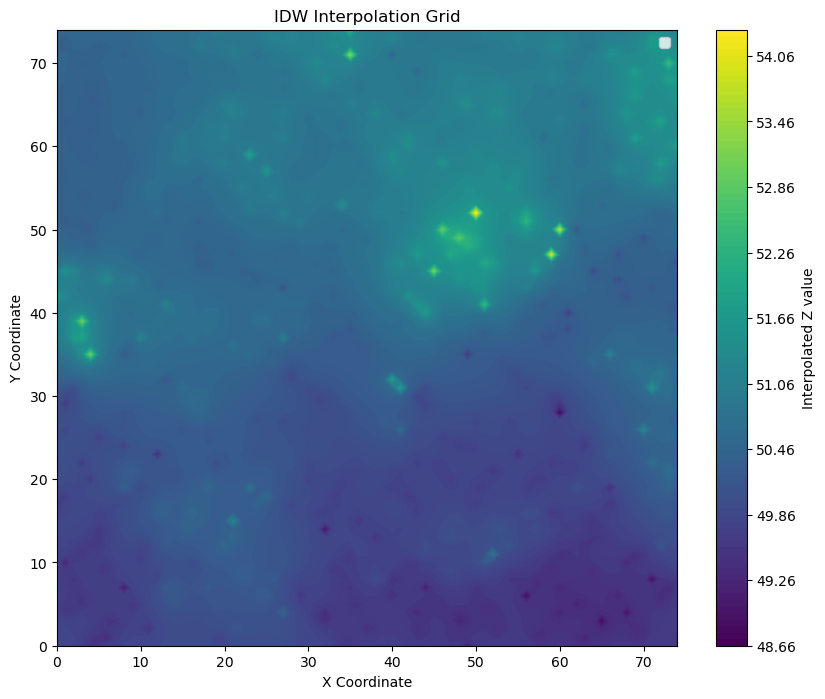

In [44]:
# 绘制插值结果
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.contourf( grid_z, levels=100, cmap='viridis')  # 插值网格
plt.colorbar(label="Interpolated Z value")
plt.title("IDW Interpolation Grid")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

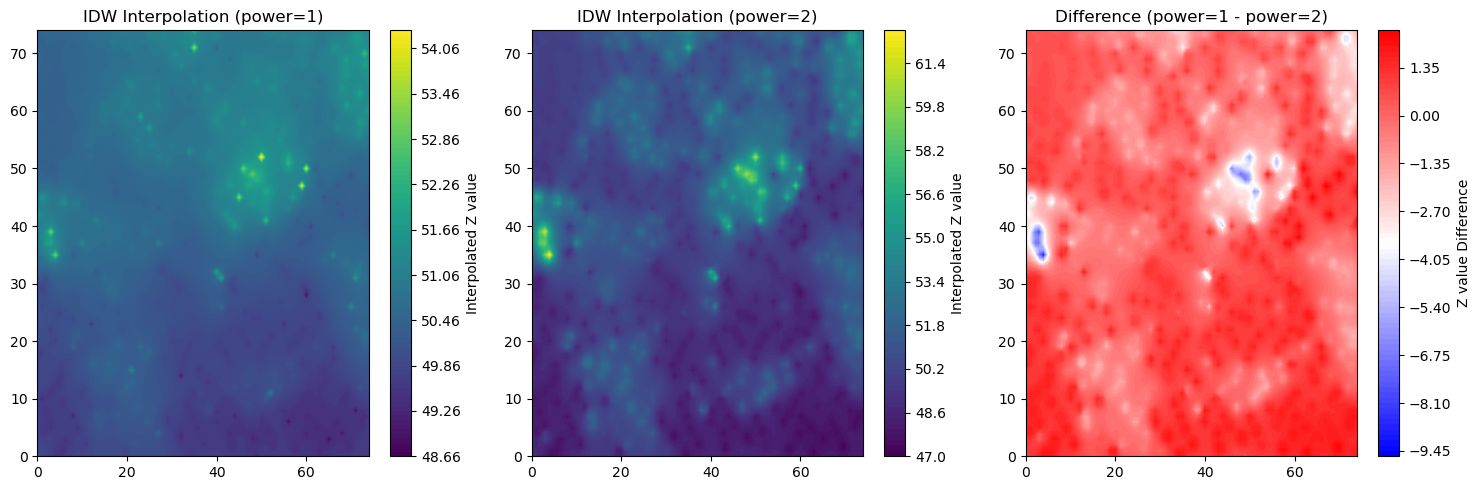

In [45]:
#不同参数power的插值结果对比,增加dem之差可视化
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.contourf(grid_z, levels=100, cmap='viridis')
plt.title("IDW Interpolation (power=1)")
plt.colorbar(label="Interpolated Z value")
plt.subplot(1, 3, 2)
plt.contourf(grid_z_power2, levels=100, cmap='viridis')
plt.title("IDW Interpolation (power=2)")
plt.colorbar(label="Interpolated Z value")
plt.subplot(1, 3, 3)
plt.contourf(grid_z - grid_z_power2, levels=100, cmap='bwr')
plt.title("Difference (power=1 - power=2)")
plt.colorbar(label="Z value Difference")
plt.tight_layout()
plt.show()